# Определение возраста покупателей с использованием компьютерного зрения

Цель проекта - разработка модели для идентификации возраста по лицу человека для сетевых супермаркетов. Предполагается, что фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы и контролировать добросовестность кассиров при продаже алкоголя.

Модель будет обучаться на размеченном наборе фотографий людей от [CHaLearn](https://chalearnlap.cvc.uab.cat/dataset/26/description/)

Обучение моделей проводится на оборудовании [Yandex Compute Cloud](https://cloud.yandex.ru/services/compute) или в Google Colab, в данном ноутбуке представлены только скрипты и результаты обучения.

Целевая метрика - MAE - не должна превышать 8

## Исследовательский анализ данных

### Импорт библиотек

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Загрузка и первичный анализ данных 

In [3]:
df = pd.read_csv('/datasets/faces/labels.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [6]:
df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


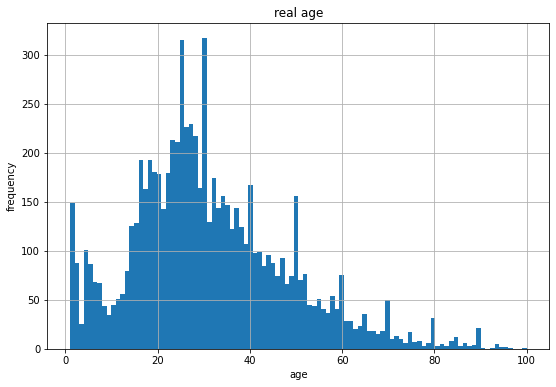

In [7]:
df['real_age'].hist(bins=100, figsize=(9,6))
plt.grid(True)
plt.title('real age')
plt.xlabel('age')
plt.ylabel('frequency')
plt.show()

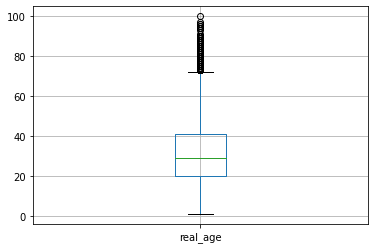

In [8]:
df.boxplot(column=['real_age']);

### Вывод нескольких изображений из датасета

In [9]:
preview_datagen = ImageDataGenerator(rescale=1./255)
preview_gen_flow = preview_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        label_mode='int',
        target_size=(224, 224),
        batch_size=10,
        class_mode='raw',
        seed=2707) 

Found 7591 validated image filenames.


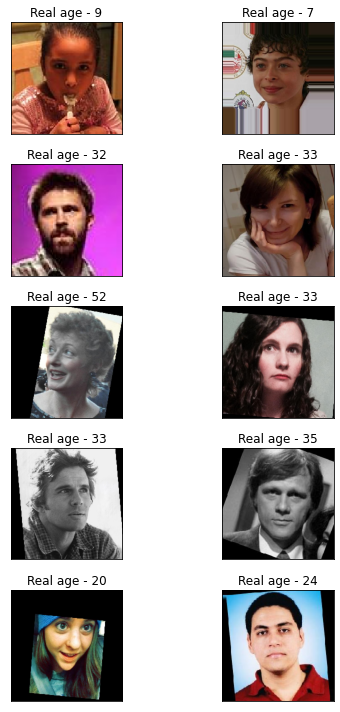

In [10]:
first_look = preview_gen_flow[0][0]
age = preview_gen_flow[0][1]

fig = plt.figure(figsize=(10,10))
for i in range(10):
    fig.add_subplot(5, 2, i+1)
    plt.imshow(first_look[i])
    plt.title(f'Real age - {age[i]}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Выводы по предобработке
- датасет содержит 7591 изображение, классифицированное по возрасту от 1 года до 100 лет
- датасет не имеет пропусков
- датасет не имеет аномалий или неадекватных значений
- предварительный просмотр фотографий и разметки показал, что по крайней мере часть датасета размечена адекватно
- явный перекос в сторону меньшего возраста (среднее - 31 год) скорее всего связано с тем, что это фотографии из соцсетей
- пик на графике для класаа "1 год" связан с тем, что вероятно, дети в возрасте меньше года также туда попадают
- в целом - младенцев чаще фотографируют и выкладывают их фотографии, чем младших школьников, что вполне понятно
- характерные пики в районе 30, 40, 50, 60, 70, 80, 90 лет могут объясняться тем, что датасет размечался вручную "на глаз", либо тем, что люди чаще фотографируются и выкладывают фотографии знаменательных дат (юбилеев). Пик 25 лет - это скорее всего окончание университета.
- **можно ожидать, что нейросеть, обученная на таком датасете, хорошо научится определять возраст молодых людей, а также, возможно, будет стремиться округлить возраст до кратного 10 числа**

## Обучение моделей

### Функция для загрузки обучающей выборки

In [11]:
def load_train(path):
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    train_datagen_flow = datagen.flow_from_dataframe(dataframe=pd.read_csv(path+'labels.csv'),
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=2807, 
    subset='training') 
    
    return train_datagen_flow 

### Функция для загрузки тестовой выборки

In [12]:
def load_test(path):
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_datagen_flow = datagen.flow_from_dataframe(dataframe=pd.read_csv(path+'labels.csv'),
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=2807, 
    subset='validation') 
    
    return test_datagen_flow

### Функция для обучения модели

In [13]:
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=len(train_data),
              validation_steps=len(test_data),
              verbose=2)
    return model

### Keras, архитектура LeNet, 8 слоев: библиотеки+модель+результат

```python
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

def create_model(input_shape):    
    optimizer = Adam(learning_rate=.00002)
    model = Sequential()
    model.add(Conv2D(filters=6,
                 kernel_size=(5, 5),
                 padding='same',
                 activation='relu',
                 input_shape=(input_shape)))
    model.add(AvgPool2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=16, kernel_size=(5, 5), padding='valid',
                 activation="relu"))
    model.add(AvgPool2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=26, kernel_size=(5, 5), padding='valid',
                 activation="relu"))
    model.add(AvgPool2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(units=1, activation='relu'))
    model.compile(loss='mean_squared_error', 
              optimizer=optimizer, metrics=[tensorflow.keras.metrics.MeanAbsoluteError()])
    return model
```

```
Train for 178 steps, validate for 60 steps

Epoch 1/10
2023-07-31 05:46:45.966867: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-07-31 05:46:46.479155: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7

178/178 - 53s - loss: 860.7362 - mean_absolute_error: 23.8789 - val_loss: 348.3954 - val_mean_absolute_error: 14.7753

Epoch 2/10
178/178 - 39s - loss: 360.8322 - mean_absolute_error: 14.7510 - val_loss: 334.2698 - val_mean_absolute_error: 14.4236

Epoch 3/10
178/178 - 39s - loss: 350.7961 - mean_absolute_error: 14.5129 - val_loss: 327.1236 - val_mean_absolute_error: 14.3097

Epoch 4/10
178/178 - 39s - loss: 340.0586 - mean_absolute_error: 14.2674 - val_loss: 313.7084 - val_mean_absolute_error: 13.9375

Epoch 5/10
178/178 - 38s - loss: 329.5300 - mean_absolute_error: 14.0136 - val_loss: 310.9035 - val_mean_absolute_error: 14.0278

Epoch 6/10
178/178 - 38s - loss: 312.2362 - mean_absolute_error: 13.6503 - val_loss: 288.9090 - val_mean_absolute_error: 13.4400

Epoch 7/10
178/178 - 36s - loss: 299.6182 - mean_absolute_error: 13.3503 - val_loss: 280.9953 - val_mean_absolute_error: 13.1255

Epoch 8/10
178/178 - 36s - loss: 295.2385 - mean_absolute_error: 13.2535 - val_loss: 280.9388 - val_mean_absolute_error: 13.2982

Epoch 9/10
178/178 - 36s - loss: 291.9873 - mean_absolute_error: 13.1680 - val_loss: 281.8606 - val_mean_absolute_error: 13.3877

Epoch 10/10
178/178 - 36s - loss: 289.4507 - mean_absolute_error: 13.1040 - val_loss: 272.5858 - val_mean_absolute_error: 12.9673

WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']

60/60 - 9s - loss: 272.5858 - mean_absolute_error: 12.9673

Test MAE: 12.9673

```

### Keras, архитектура ResNet50, предобученная на ImageNet: библиотеки+модель+результат

```python
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.applications.resnet50 import ResNet50

def create_model(input_shape):
 
    optimizer = Adam(learning_rate=.00005)
    backbone = ResNet50(input_shape=(224, 224, 3),
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    model.compile(loss='mean_squared_error', 
              optimizer=optimizer, metrics=[tensorflow.keras.metrics.MeanAbsoluteError()])
    return model
```

```
Train for 178 steps, validate for 60 steps

Epoch 1/10
2023-07-31 06:35:18.485109: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10

2023-07-31 06:35:23.011620: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7

178/178 - 125s - loss: 305.2767 - mean_absolute_error: 12.5831 - val_loss: 914.4756 - val_mean_absolute_error: 25.5287

Epoch 2/10
178/178 - 56s - loss: 63.4868 - mean_absolute_error: 6.0291 - val_loss: 911.6777 - val_mean_absolute_error: 25.4882

Epoch 3/10
178/178 - 56s - loss: 30.8564 - mean_absolute_error: 4.2670 - val_loss: 548.9585 - val_mean_absolute_error: 18.3979

Epoch 4/10
178/178 - 55s - loss: 19.3555 - mean_absolute_error: 3.4137 - val_loss: 179.5462 - val_mean_absolute_error: 10.0750

Epoch 5/10
178/178 - 53s - loss: 14.9535 - mean_absolute_error: 3.0308 - val_loss: 85.2098 - val_mean_absolute_error: 6.9939

Epoch 6/10
178/178 - 38s - loss: 13.1774 - mean_absolute_error: 2.8348 - val_loss: 82.5612 - val_mean_absolute_error: 6.8621

Epoch 7/10
178/178 - 52s - loss: 12.5201 - mean_absolute_error: 2.7268 - val_loss: 106.0750 - val_mean_absolute_error: 8.1429

Epoch 8/10
178/178 - 50s - loss: 12.0768 - mean_absolute_error: 2.6704 - val_loss: 82.9103 - val_mean_absolute_error: 7.0565

Epoch 9/10
178/178 - 47s - loss: 10.8921 - mean_absolute_error: 2.5572 - val_loss: 72.4246 - val_mean_absolute_error: 6.4896

Epoch 10/10
178/178 - 47s - loss: 9.5244 - mean_absolute_error: 2.3452 - val_loss: 72.5656 - val_mean_absolute_error: 6.4571

WARNING:tensorflow:sample_weight modes were coerced from

  ...

    to  

  ['...']

60/60 - 10s - loss: 72.5656 - mean_absolute_error: 6.4571

Test MAE: 6.4571

```

### Сверточная нейросеть в PyTorch

```python

import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms, utils
from torchvision.transforms import Resize
from torchvision.io import read_image
from torch import nn
from skimage import io

import warnings
warnings.filterwarnings("ignore")

plt.ion()

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

class Faces(Dataset):
    def __init__(self, annotations_file, img_dir, transform, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file).drop(['apparent_age', 'worker_age', 'worker_gender'], axis=1)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path).to(torch.float32)
        label = np.float32(self.img_labels.iloc[idx, 1])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

transformer = Resize((225, 225))
face_dataset = Faces(annotations_file='sample_data/gt_train.csv',
                                    img_dir='sample_data/img/', transform=transformer)
train_size = int(0.75 * len(face_dataset))
test_size = len(face_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(face_dataset, [train_size, test_size])

look_flow = DataLoader(face_dataset, batch_size=10, shuffle=True, num_workers=1,
                           pin_memory=True)

fig = plt.figure(figsize=(10,10))
for IMG, age in (look_flow):
    for i in range(10):
        fig.add_subplot(5, 2, i+1)
        plt.imshow(IMG[i].to(torch.uint8).permute(1, 2, 0))
        plt.title(f'Real age - {age[i]}')
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
        #print(IMG[i].dtype)
        #print(age[i].dtype)
        #print(f"Type of X: {np.dtype(IMG[i])}")
        #print(f"Type of age: {np.dtype(age)}")
    break

train_flow = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=1,
                           pin_memory=True)
test_flow = DataLoader(test_dataset, batch_size=8, shuffle=True, num_workers=1,
                           pin_memory=True)

class MyNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 6, (5,5)),
            nn.ReLU(),
            nn.AvgPool2d(5, stride=1),
            nn.Conv2d(6, 16, (5,5)),
            nn.ReLU(),
            nn.AvgPool2d(5, stride=1),
            nn.Flatten(),
            nn.LazyLinear(1),
            nn.ReLU()
        )
        #self.float()

    def forward(self, x):
        return self.layers(x)

model = MyNN().to(device)
print(model)

model = MyNN()
loss_t = nn.MSELoss()
loss_v = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

n_epochs = 10
for epoch in range(n_epochs):
    train_features, train_labels = next(iter(train_flow))
    y_pred = model(train_features)
    loss = loss_t(y_pred, train_labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    MAE = 0
    valid_features, valid_labels = next(iter(test_flow))
    y_pred = model(valid_features)
    MAE = loss_v(y_pred, valid_labels)

    print(f'Epoch: {epoch} --- MAE {MAE}')
```

```
Epoch: 0 --- MAE 1168.4100341796875
Epoch: 1 --- MAE 369.6968994140625
Epoch: 2 --- MAE 28.125
Epoch: 3 --- MAE 31.625
Epoch: 4 --- MAE 19.25
Epoch: 5 --- MAE 29.125
Epoch: 6 --- MAE 30.25
Epoch: 7 --- MAE 24.875
Epoch: 8 --- MAE 30.625
Epoch: 9 --- MAE 24.5
```

## Анализ обученной модели

В ходе исследования было проверено 3 модели:

| Модель | МАЕ | Вывод |
|---|---|---|
|Сверточная нейросеть с 8 слоями по архитектуре LeNet|13,0|Не удовлетворяет требованиям|
|ResNet50, предобученная на датасете ImageNet|6,5|Удовлетворяет требованиям|
|Сверточное что-то в PyTorch|24,5|Не удовлетворяет требованиям|


**Модель, удовлетворяющая требованиям (MAE <= 8):**
- ✅ пригодна для системы рекомендаций товаров на основе возрастной группы покупателя;
- ❌ непригодна для проверки добросовестности кассира, продающего алкоголь (требуемая точность определения возраста может составлять 1 месяц). Это я как человек, который в свои 30+ пиво без паспорта купить не может, говорю:)